In [1]:
from pyspark.sql import functions as F

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1580051229973_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
input_bucket = 's3://joonbigdataanalytics'
complaint_input_path = '/Data/Customer_Complaints.json'

customer_complaints = spark.read.json(input_bucket + complaint_input_path)

# Show some basic information aggregated across the complaints dataset to validate the data has loaded correctly
# Show date ranges
customer_complaints.agg(F.min("Date received"), F.max("Date received")).show()
# Show product types
customer_complaints.select("Product").distinct().show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+------------------+
|min(Date received)|max(Date received)|
+------------------+------------------+
|        01/01/2012|        12/31/2018|
+------------------+------------------+

+--------------------+
|             Product|
+--------------------+
|     Debt collection|
|    Virtual currency|
|         Payday loan|
|     Money transfers|
|Money transfer, v...|
|Checking or savin...|
|            Mortgage|
|        Prepaid card|
|Credit card or pr...|
|    Credit reporting|
|       Consumer Loan|
|Credit reporting,...|
|         Credit card|
|Bank account or s...|
|Vehicle loan or l...|
|Other financial s...|
|        Student loan|
|Payday loan, titl...|
+--------------------+

In [4]:
zip_geo_input_path = '/Data/us-zip-code-latitude-and-longitude.csv'
zip_geo = spark.read.csv(input_bucket + zip_geo_input_path, header = True, multiLine=True, inferSchema=True, sep=";")

zip_geo.agg(F.min("Timezone"), F.max("Timezone")).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-------------+
|min(Timezone)|max(Timezone)|
+-------------+-------------+
|          -10|           -4|
+-------------+-------------+

In [5]:
tax_data_input_path = '/Data/15zpallagi.csv'
tax_data = spark.read.csv(input_bucket + tax_data_input_path, header = True, multiLine=True, inferSchema=True)

tax_data.agg(F.min("N1"), F.max("N1")).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+
|min(N1)|  max(N1)|
+-------+---------+
|    0.0|6231480.0|
+-------+---------+

In [6]:
# Feature Engineering: Reduce the 18 possible product categories down to a more manageable 6 different categories of product
# Build up the map of translations
mapping = {
    "Debt collection": "DebtCollection",
    "Virtual currency": "NonBank",
    "Payday loan": "Loans",
    "Money transfers": "Transfers",
    "Money transfer, virtual currency, or money service": "Transfers",
    "Checking or savings account": "BankAccount",
    "Mortgage": "BankAccount",
    "Prepaid card": "BankAccount",
    "Credit card or prepaid card": "BankAccount",
    "Credit reporting": "CreditService",
    "Consumer Loan": "Loans",
    "Credit reporting, credit repair services, or other personal consumer reports": "CreditService",
    "Credit card": "BankAccount",
    "Bank account or service": "BankAccount",
    "Vehicle loan or lease": "Loans",
    "Other financial service": "NonBank",
    "Student loan": "Loans",
    "Payday loan, title loan, or personal loan": "Loans"
}
# Select out the required information, and remap the product values at the same time
complaint_count_src = customer_complaints.select(["Company", "Complaint ID", "Date received", "Issue", "Product", \
                                                  "Sub-issue", "Sub-product", "ZIP code"]).replace(to_replace=mapping, subset=['Product'])
# Then group by the zip code (which will roll up the complaints per product per zip), and at the same time
# Pivot the data so that 6 possible rows of data per ZIP become one row with 6 columns of summed values (and null where that category didn't appea in the zip)
zipcode_complaint_count = complaint_count_src.groupBy('ZIP code').pivot('Product').count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Data in the tax file is banded by adjusted gross income brackets. Roll the individual banded numbers of returns and total income into a sum per zip
rollup_tax = tax_data.select(F.col("zipcode"), F.col("N1").alias("NumReturns"), F.col("A02650").alias("TotalIncome")).groupBy('zipcode').sum()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
complaints = zipcode_complaint_count.join(zip_geo.select(["Zip","City","State","Latitude","Longitude"]), F.col("ZIP code") == F.col("Zip"), 'inner')
complaints = complaints.join(rollup_tax.select(F.col("zipcode"), F.col("sum(NumReturns)").alias("NumReturns"), F.col("sum(TotalIncome)").alias("TotalIncome")), F.col("ZIP code") == F.col("zipcode"), 'inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
complaints.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-----------+-------------+--------------+-----+-------+---------+-----+-------------+-----+---------+----------+-------+----------+-----------+
|ZIP code|BankAccount|CreditService|DebtCollection|Loans|NonBank|Transfers|  Zip|         City|State| Latitude| Longitude|zipcode|NumReturns|TotalIncome|
+--------+-----------+-------------+--------------+-----+-------+---------+-----+-------------+-----+---------+----------+-------+----------+-----------+
|   80422|          3|         null|          null|    2|   null|     null|80422|   Black Hawk|   CO|39.813744|-105.50875|  80422|    1660.0|   111149.0|
|   32773|         34|           16|            35|    9|      1|        1|32773|      Sanford|   FL|28.769173| -81.27631|  32773|   14140.0|   548499.0|
|   92027|         64|           44|            32|    8|   null|        4|92027|    Escondido|   CA|33.142706|-117.03049|  92027|   24700.0|  1308800.0|
|   19132|         40|           71|            23|   10|   null|        1|1

In [15]:
save_name = "/Data/ComplaintStats.json"
#complaints.write.json(input_bucket + save_name)
complaints.repartition(1).write.json(input_bucket + save_name)
#complaints.toJSON().saveAsTextFile(input_bucket + save_name)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
sc.install_pypi_package("pandas==0.25.1") #Install pandas version 0.25.1 
sc.install_pypi_package("matplotlib", "https://pypi.org/simple") #Install matplotlib from given PyPI repository

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
#sc.install_pypi_package("geos")
#sc.install_pypi_package("geopandas")
#sc.install_pypi_package("contextily")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package already installed for current Spark context!
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/context.py", line 1110, in install_pypi_package
    raise ValueError("Package already installed for current Spark context!")
ValueError: Package already installed for current Spark context!



In [60]:
#sc.install_pypi_package("Cython")
#sc.install_pypi_package("NumPy")
#sc.uninstall_package("GEOS")
#sc.install_pypi_package("GEOS==3.3.3")
#sc.install_pypi_package("Shapely")
#sc.install_pypi_package("pyshp")
#sc.install_pypi_package("PROJ==4.9.0")
#sc.uninstall_package("PROJ")
#sc.install_pypi_package("six")
#sc.install_pypi_package("contextily")



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


ERROR: Could not find a version that satisfies the requirement basemap (from versions: none)
ERROR: No matching distribution found for basemap

In [11]:
complaints_frame = complaints.toPandas()
complaints_frame = complaints_frame.fillna(0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
complaints_frame['TotalComplaints'] = complaints_frame.BankAccount + complaints_frame.CreditService + complaints_frame.DebtCollection + complaints_frame.Loans + \
    complaints_frame.NonBank + complaints_frame.Transfers

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
continental_us_complaints = complaints_frame[~complaints_frame['State'].isin(['AK', 'HI'])]


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
%matplotlib inline

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

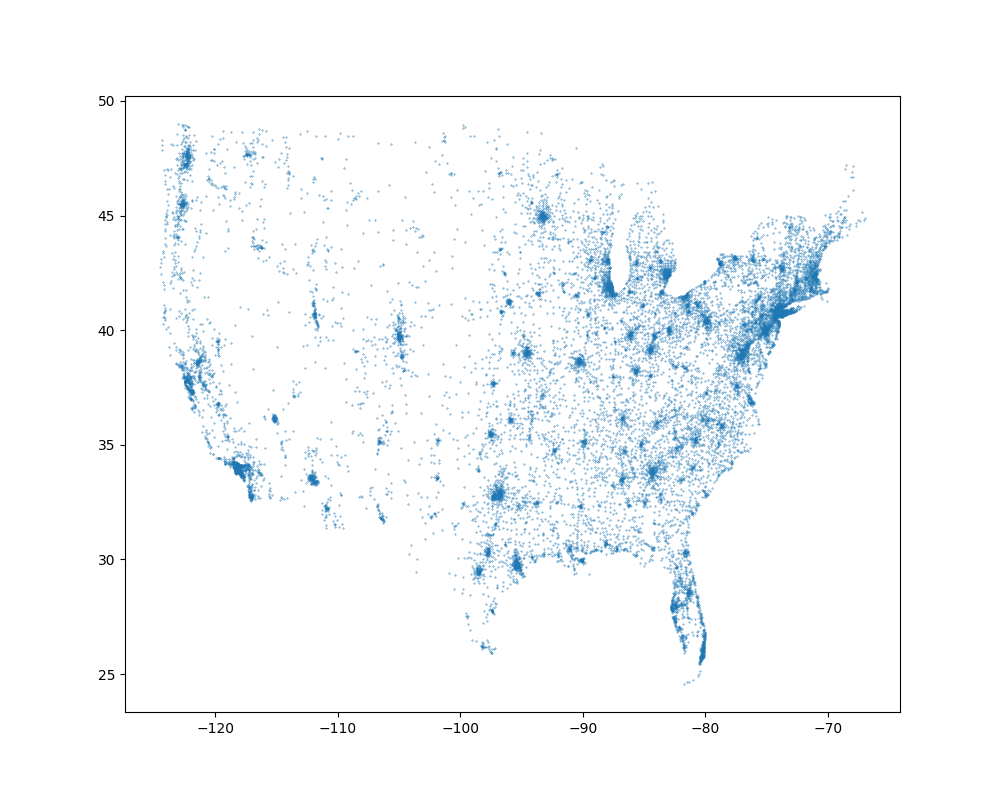

In [21]:

# Import the necessary packages and modules
import matplotlib.pyplot as plt
import numpy as np

# Set the plot size
plt.figure(figsize=(10, 8))

# Scatter plot the Long and Lat of complaints
plt.scatter(continental_us_complaints['Longitude'].values, continental_us_complaints['Latitude'].values, 0.1)
plt.show()
%matplot plt

In [22]:
# stats for total complaints
continental_us_complaints.TotalComplaints.describe()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

count    15833.000000
mean        45.866797
std         78.101102
min          1.000000
25%          2.000000
50%          6.000000
75%         64.000000
max       1068.000000
Name: TotalComplaints, dtype: float64

In [26]:
# R1: Are there complaints hotspots across the US?

# Step 1: Add ComplaintsPerTaxReturn stat
continental_us_complaints['ComplaintsPerTaxReturn'] = continental_us_complaints.TotalComplaints / continental_us_complaints.NumReturns

continental_us_complaints['ComplaintsPerTaxReturn'].describe()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

count    15833.000000
mean         0.003691
std          0.004416
min          0.000097
25%          0.000847
50%          0.002083
75%          0.005241
max          0.146154
Name: ComplaintsPerTaxReturn, dtype: float64

In [75]:
stats = complaints_frame.ComplaintsPerTaxReturn.describe()
# find all zip codes with complaints 2 standard deviations from the statistical average of complaints per tax return
outliers = continental_us_complaints[continental_us_complaints['ComplaintsPerTaxReturn'] > (stats['mean'] + (stats['std'] * 2))]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [76]:
BBox = (outliers.Longitude.min(), outliers.Longitude.max(), outliers.Latitude.min(), outliers.Latitude.max())
BBox

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(-124.37144, -68.44607, 24.91828, 48.283826)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

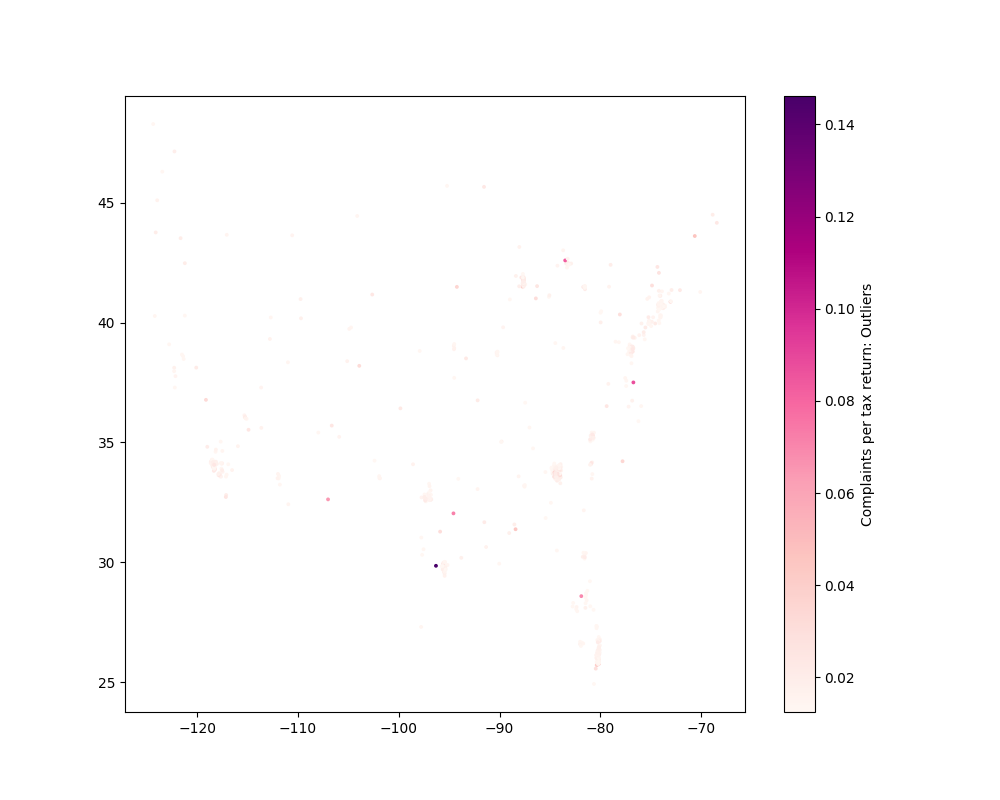

In [77]:
# Import the necessary packages and modules
import matplotlib.pyplot as plt
import numpy as np

# Set the plot size
plt.figure(figsize=(10, 8))

# Scatter plot the Long and Lat of complaints
plt.scatter(outliers['Longitude'].values, outliers['Latitude'].values, 3, c=outliers['ComplaintsPerTaxReturn'].values, cmap = 'RdPu')
#plt.scatter(complaints_frame['Longitude'].values, complaints_frame['Latitude'].values, 0.1, c=complaints_frame['ComplaintsPerTaxReturn'].values, cmap = 'Oranges')

cbar = plt.colorbar()
cbar.set_label("Complaints per tax return: Outliers")

plt.show()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

count    15934.000000
mean         0.003683
std          0.004406
min          0.000097
25%          0.000847
50%          0.002083
75%          0.005219
max          0.146154
Name: ComplaintsPerTaxReturn, dtype: float64